In [82]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

from PIL import Image
from io import BytesIO

import tensorflow as tf
# from tensorflow.keras.applications import vit   
# from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, applications, callbacks
from tensorflow.keras.utils import to_categorical
import warnings

warnings.filterwarnings("ignore")

In [15]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPUs detected:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs detected. Running on CPU.")

GPUs detected:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [16]:
csv_file = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
image_folder = '/kaggle/input/isic-2024-challenge/train-image'

test_file = "/kaggle/input/isic-2024-challenge/test-metadata.csv"

In [17]:
df = pd.read_csv(csv_file)
# df['target'] = df['target'].astype(int)

In [19]:
target_0 = df[df['target'] == 0]
target_1 = df[df['target'] == 1]


target_0_downsampled = target_0.sample(n=1000, random_state=42)


df_downsampled = pd.concat([target_0_downsampled, target_1], axis=0).reset_index(drop=True)

df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original dataset size: {len(df)}")
print(f"Downsampled dataset size: {len(df_downsampled)}")
print(df_downsampled['target'].value_counts())


Original dataset size: 401059
Downsampled dataset size: 1393
target
0    1000
1     393
Name: count, dtype: int64


In [20]:
df = df_downsampled

In [21]:
train_idx, temp_idx = train_test_split(df.index, test_size=0.2, stratify=df['target'], random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=df.loc[temp_idx, 'target'], random_state=42)


In [22]:
train_df = df.loc[train_idx].copy()
val_df = df.loc[val_idx].copy()
test_df = df.loc[test_idx].copy()

In [23]:
train_image_path = image_folder+"/image/" + train_df['isic_id'] + '.jpg'
val_image_path = image_folder+"/image/" + val_df['isic_id'] + '.jpg'
test_image_path = image_folder +"/image/"+ test_df['isic_id'] + '.jpg'

In [24]:
train_df['image_path'] = train_image_path
val_df['image_path'] = val_image_path
test_df['image_path'] = test_image_path

In [25]:
train_df.target.iloc[0:1]

380    0
Name: target, dtype: int64

(-0.5, 116.5, 116.5, -0.5)

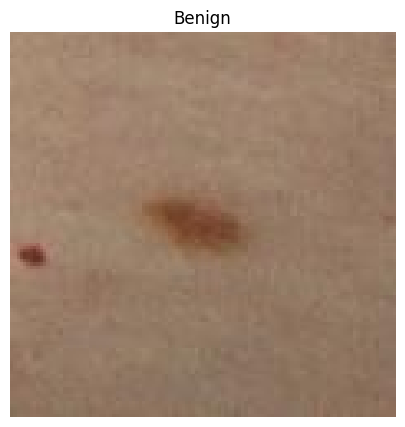

In [26]:
img = Image.open(train_df.image_path.iloc[20])

plt.figure(figsize=(10, 5))
plt.title("Benign" if train_df.target.iloc[20]==0 else "Malignant")
plt.imshow(img)  
plt.axis('off') 

In [27]:
def create_datagen(dataframe, image_folder, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15,
            horizontal_flip=True,
            featurewise_center=True,  
            featurewise_std_normalization=True
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=image_folder,
        
        x_col='image_path',
        y_col='target',
        target_size=(224, 224),
        class_mode='binary',
        batch_size=32,
        shuffle=True
    )
    return generator

In [28]:
def create_densenet_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = applications.DenseNet121(weights=None, include_top=False, input_shape=input_shape)
    base_model.trainable = True  # False Freeze the base model, will have 0 trainable parameters
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    # model.summary()
    return model

In [29]:
train_df['target'] = train_df['target'].astype(str)
val_df['target'] = val_df['target'].astype(str)
test_df['target'] = test_df['target'].astype(str)

In [30]:
train_gen = create_datagen(train_df, image_folder, augment=True)
val_gen = create_datagen(val_df, image_folder,augment=True)
test_gen = create_datagen(test_df, image_folder,augment=True)

# will take time

Found 1114 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.


In [31]:
densenet = create_densenet_model(num_classes=2)
densenet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
densenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [33]:
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

history = densenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100
    # callbacks=[reduce_lr,early_stopping]
)

Epoch 1/100


I0000 00:00:1732498947.367047     171 service.cc:145] XLA service 0x7e39e00020c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732498947.367103     171 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732499032.352016     171 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.6569 - loss: 0.7378 - val_accuracy: 0.7194 - val_loss: 1.5074
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - accuracy: 0.7833 - loss: 0.5129 - val_accuracy: 0.7194 - val_loss: 0.6336
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 339ms/step - accuracy: 0.7883 - loss: 0.5200 - val_accuracy: 0.7194 - val_loss: 0.8278
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 340ms/step - accuracy: 0.7953 - loss: 0.4715 - val_accuracy: 0.7194 - val_loss: 0.9073
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 333ms/step - accuracy: 0.7969 - loss: 0.4686 - val_accuracy: 0.7194 - val_loss: 0.6654
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step - accuracy: 0.8073 - loss: 0.4395 - val_accuracy: 0.7194 - val_loss: 0.8248
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 342ms/step - accuracy: 0.7895 - loss: 0.4973 - val_accuracy: 0.7194 - val_loss: 0.9661
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.8171 - loss: 0.3914 - val_accuracy: 

In [64]:
# history.history['accuracy']
print(f"Highest validation accuracy is: {max(history.history['val_accuracy']):.2f}")

Highest validation accuracy is: 0.91


In [66]:
max_val_accuracy = max(history.history['val_accuracy'])

# Get the index of the highest validation accuracy
max_val_accuracy_index = history.history['val_accuracy'].index(max_val_accuracy)

# Get the corresponding loss using the index
corresponding_loss = history.history['val_loss'][max_val_accuracy_index]

print(f"Highest validation accuracy is: {max_val_accuracy:.4f}")
print(f"Corresponding loss is: {corresponding_loss:.4f}")

Highest validation accuracy is: 0.9065
Corresponding loss is: 0.2831


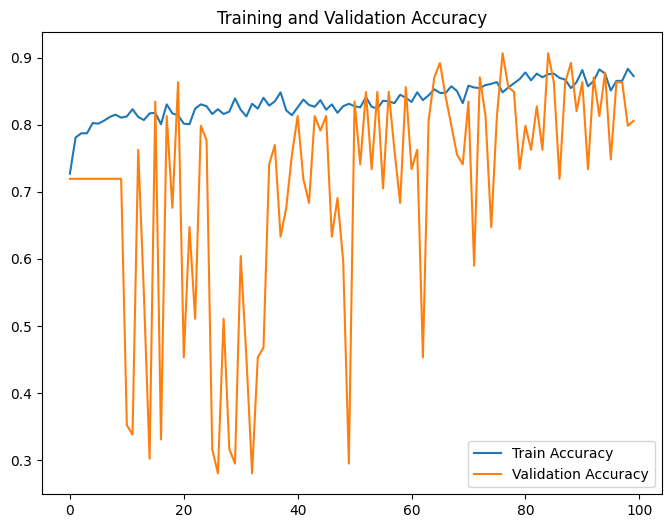

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

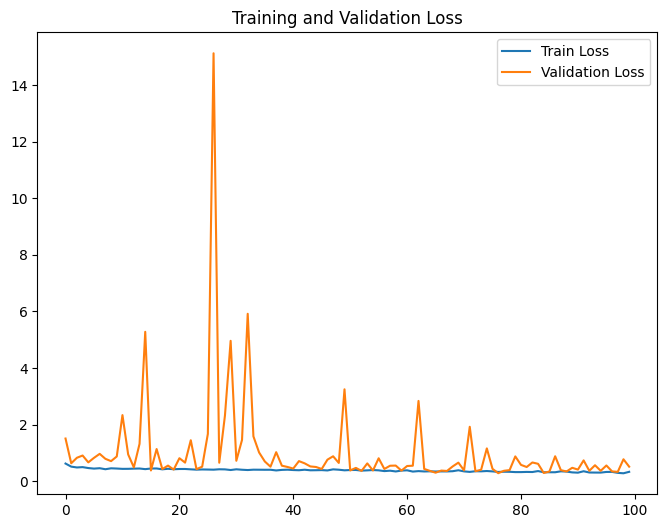

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [37]:
test_loss, test_acc =densenet.evaluate(test_gen)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7469 - loss: 0.7599  
Test Loss: 0.7170, Test Accuracy: 0.7643


In [38]:
y_true = test_gen.classes
y_pred_probs = densenet.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step 


0.9064748287200928

Confusion Matrix

<Figure size 600x600 with 0 Axes>

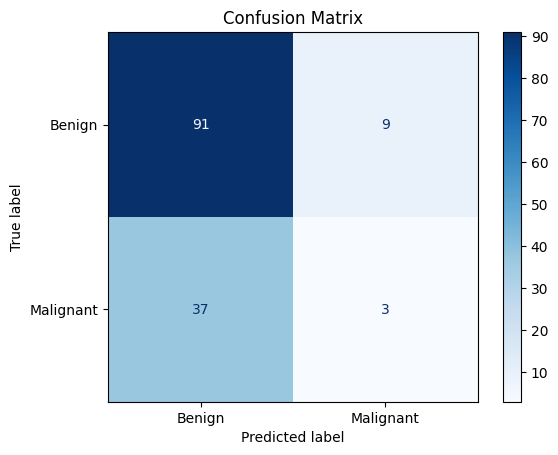

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

# Plot confusion matrix
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


ROC curve

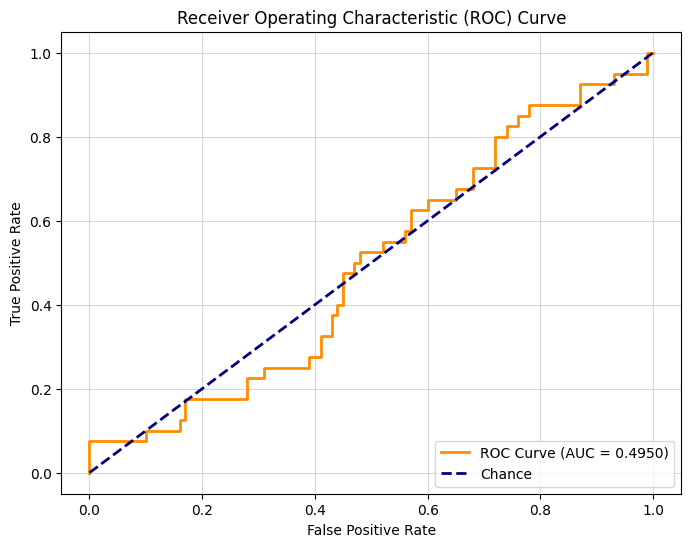

In [40]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

Heatmap

In [67]:
# import pandas as pd
# import seaborn as sns
# from sklearn.metrics import classification_report


# report = classification_report(y_true, y_pred, target_names=['Benign', 'Malignant'], output_dict=True)
# report_df = pd.DataFrame(report).transpose()

# # heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Classification Report Heatmap')
# plt.show()


In [42]:
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

try:
    auc = roc_auc_score(y_true, y_pred_probs[:, 1])
    print(f"AUC: {auc:.4f}")
except ValueError:
    print("AUC calculation failed due to lack of positive/negative samples.")

              precision    recall  f1-score   support

      Benign       0.71      0.91      0.80       100
   Malignant       0.25      0.07      0.12        40

    accuracy                           0.67       140
   macro avg       0.48      0.49      0.46       140
weighted avg       0.58      0.67      0.60       140

AUC: 0.4950


***VIT (vision transformer model***

In [43]:
# def create_vit_model(input_shape=(224, 224, 3), num_classes=2):
#     # Load a pretrained Vision Transformer
#     base_model = vit.ViTClassifier(
#         input_shape=input_shape,
#         include_top=False,  # Exclude the default classification head
#         pooling='token',    # Use the [CLS] token for classification
#         weights='imagenet21k+imagenet1k',
#     )
#     base_model.trainable = True  # Fine-tune the base model

#     # Add a custom classification head
#     model = models.Sequential([
#         base_model,
#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes, activation='softmax')  # For binary classification, use `softmax`
#     ])
#     return model

***Attention u-net***

In [44]:
# def attention_block(x, g, inter_channels):
#     """Attention block for the Attention U-Net."""
#     theta_x = layers.Conv2D(inter_channels, kernel_size=1)(x)
#     phi_g = layers.Conv2D(inter_channels, kernel_size=1)(g)
#     f = layers.Activation('relu')(layers.add([theta_x, phi_g]))
#     psi_f = layers.Conv2D(1, kernel_size=1, activation='sigmoid')(f)
#     return layers.multiply([x, psi_f])

# def conv_block(x, filters):
#     """Basic convolutional block for the U-Net."""
#     x = layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')(x)
#     x = layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')(x)
#     return x

# def encoder_block(x, filters):
#     """Encoder block with max pooling."""
#     x = conv_block(x, filters)
#     p = layers.MaxPooling2D(pool_size=(2, 2))(x)
#     return x, p

# def decoder_block(x, skip, filters):
#     """Decoder block with attention mechanism."""
#     x = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(x)
#     x = attention_block(skip, x, filters // 2)  
#     x = layers.Concatenate()([x, skip])
#     x = conv_block(x, filters)
#     return x

# def attention_unet(input_shape=(224, 224, 3), num_classes=1):
#     """Attention U-Net architecture."""
#     inputs = layers.Input(input_shape)
    
    
#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

    
#     b = conv_block(p4, 1024)

   
#     d1 = decoder_block(b, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     # Output layer
#     outputs = layers.Conv2D(num_classes, kernel_size=1, activation='sigmoid')(d4)

#     return models.Model(inputs, outputs)


# att_unet = attention_unet(input_shape=(224, 224, 3), num_classes=1)


# att_unet.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )


# att_unet.summary()

In [45]:
# att_unet_history = att_unet.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=100
#     # callbacks=[reduce_lr]
# )

In [46]:
test_df = pd.read_csv(test_file)

In [48]:
image_ids = test_df['isic_id']


keys: <KeysViewHDF5 ['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740']>


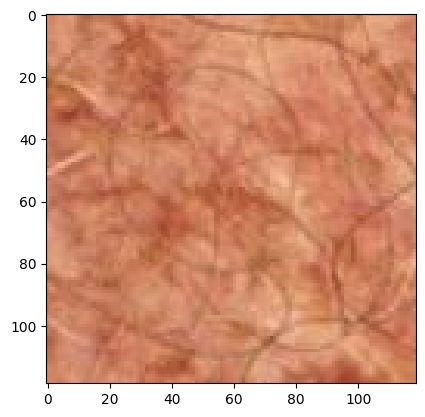

In [83]:
import h5py

filepath = '/kaggle/input/isic-2024-challenge/test-image.hdf5'

images = []

with h5py.File(filepath,"r") as f:
    print("keys: %s" %f.keys())
    # break
    for key in f.keys():
        data = f[key][()]
        # images = np.array(data)
        plt.imshow(Image.open(BytesIO(data)))
        # print(data)

In [84]:
def load_hdf5_images(filepath, target_size=(224, 224,3)):
    images = []
    image_ids = []
    with h5py.File(filepath, "r") as f:
        for key in f.keys():
            image = f[key][()]
            # print(image.shape)
            # Resize image just in case
            
            images.append(image)
            image_ids.append(key)  
            
    return np.array(images), image_ids


In [85]:
images, image_ids = load_hdf5_images(filepath)

In [86]:
images = images.astype('float32') / 255.0

# Predict
predictions = model.predict(images)


ValueError: could not convert string to float: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x8d\x00\x8d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe1\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf1\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xff\xc4\x00\x1f\x01\x00\x03\x01\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x11\x00\x02\x01\x02\x04\x04\x03\x04\x07\x05\x04\x04\x00\x01\x02w\x00\x01\x02\x03\x11\x04\x05!1\x06\x12AQ\x07aq\x13"2\x81\x08\x14B\x91\xa1\xb1\xc1\t#3R\xf0\x15br\xd1\n\x16$4\xe1%\xf1\x17\x18\x19\x1a&\'()*56789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x82\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\xd2\xd3\xd4\xd5\xd6\xd7\xd8\xd9\xda\xe2\xe3\xe4\xe5\xe6\xe7\xe8\xe9\xea\xf2\xf3\xf4\xf5\xf6\xf7\xf8\xf9\xfa\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x11\x00?\x00\xe4\xf2\x01eU\xcb\x1a\xae\xdcJ\x03\r\xcc\x7fJ\xb9\x01S\xc9\xc7\x1d3AhL\xbe`\x18 u#\xa5y\x87\xb0$\xcc\xad\n\xbb\x01\x85<\x01REl\xab\x18v`O~i\xb0\xc4\xb3e\xdb\x01{\x02)\xc0\x9d\xa0\x0e\x80\xe0\xd3\r\xd8\xf6\x99\x142\xed\xed\x9a\xab\x04D\xfe\xf3\x1c\x9fJ\xb1q\xf2\xc3\x92FH\xc7N\x95$hV\x01\xb3\x8cqHa\xca\xa9%\xb01\xd0\xd5h\x14\xcd+H\xdfp\x1e\x9e\xb5%\xc1V\x8c@K\x06c\xda\xa7\x85\xa2\x8e\xdf`\x18 v\xa2\xf6\xd4\x1e\xba\x12\x19\x91>\xe89<Tor\xe52sP\xac\xad#2\x84\xcf\xbe:T{\xc6\xfd\xa4\xfc\xdd\xe964\x8b\n\xea\xb9\xdd\xc6EE"\x17C\x8c\x90=*\x13}\x0cs4n\xad\xc7\xb5O\xe6\xab\xc0\xca\x80\x8d\xc3\x8e)\xd8bA\x1e\xd5\x19\xc7=\xaa\xcc\x90.\xe58\xe6\xaa\xc42B\x92q\x8c\xe7\x15b\x07!\x8a;\xe7\x14=\xc9kA\xd2[\x15u\xe3\xe5\'\xa7\xad;xE\xdb\x8e)\xcf&\xd22\xc4\x9f\xe5T\xe5\x01X\xba\x92s\xd6\x95\x84\x89\x81&7S\x80\x088\xe2\x9a\xab\xb5F[\'\xebH\xec\x1c*\x01\xd7\xd2\xa1\xf2\xc8f\xf7\xa2\xe3\x08c%\xf7\x8e\x9d\xc5Cs\x0bI&\xc4\'g|T\xf2N\xa8\x02\xc5\xf7\x8dH\x8b\xb63\x90O\x19\xcfz\xa4"\xa8y`E@\xa5\x87\xa59\xee\x08r\x02\xfd\xeeO\xd6\xa6v^\x87\x83\xd2\xab\xba\x85\x07\xe5\xe3\xde\x93)"\xbc\x93\xc8\n\x82A\xc9\xe8j\xc8\xbb\x90r0Gz\xaam\xdeY\x0b\x8e\x07lU\x8bX\x19\xba\xf5\x1ds\xde\x84\xae\r\x93;\xb3\x11#/\xcdB\x90\xc9\xf3\x03\x9fJ|\x84\xe0\x0c\x1cT!\xc7\x9b\x85\xec(`\x91f7\x00\x80>Ri<\xb1\xe7n\xc6I\xa4\x0b\x91\xbb\xbf\xa5/U\xcf<u\xe6\x90\xc5\x9a\xde\x02D\x81C8\xecEG\xe6\x82~\xe1\xf7\xa26b\xc4\xe4\x12zf\x91\xf78c\x8cP"\x16\x97j\xb0\xc1\x18=\xa9a\x1d\xdd\xb0}{\xd2\x159\xc9\x00z\xe6\x9a\x89\xd4;\xf1\x91\xde\x93\x0b\x16\xe6`QHl\xe3\xad52\xe4\xb9\x1c\xfd)D\x01\x91\xd4\x1c\xa8\xe79\xa9\x81\x89c\xda:\xd3\x11P\xb9\x8et\xf4\xed\xedS\xefbI\x18\xc7\xbd5\x95^VV\x1d\x85"\xf1\x90\xc7\xa7Ji\\w\xb1^(\\\xc9\xe7go\xa6j\xc9\xb9d\x048\x1f^\xd5\x03\xc8A\n9\x1e\x95"|\xcaB\xe1\xbfZD\x8e\xdb\x1c\xa9\x86\xe7=\xaa)\xc0\x19\xc7\x1d\xa9Lf\x14\xfd\xdb\xf5\xfe\x1a\xac\xb2\xc8\xf2yl\xb8\xe7\xafjv\xb8\xefb\xcc\x0c\xd1\x0f%\x00>\xa6\xa4\x90\xbe\xd5\x1d1\xc0\xc5H\xab\xe4\xa6W\x00\xf4\xa8\xcb\x19}\xff\x00\x95\x17\x0b\rnS#?\x8dR\x91\xce\xf0\x01\xeaM]\xdf\x91\x8e\x80T&8\xe4\xca\xb1\x19\xfa\xd2-\x15&\xbe\x95%X\xe2<\xfa\xd6\xa2H$\x8bj\xfd\xecrMg\xc7o\x1a\x1f1\xb0s\xc0\xcdY\x8c|\x85\xc1\xc8=y\xc6*\xb4B\xdd\x92+\xc7\x1a\xf7\xc8\xee)\x8d6U\xc7<\x8ej0\xc0\x9c\xe7\x8e\xf9\xa7$ly\xc8\x075,-a\x8b6\xef\x94\x8e\x07\xb5X\x8e?2N8_ZH\xe2\x07*0}\xb1V\xa2\x8aEU\xda\xb8^\xe4\x9a\x12\x13\x06\x84A\x0b\x92O5\x02\xfc\xd8\xc7\x04\xf7\xab\xb2\xb2\xacLI\xdc\xd8\xefQ\x16Q\x18\n\xb9b;P\x04\x05\x8cs\x13\xd5\xb0:\xd4\x8e\xfev\t^\x95ZFu\x98\x17\xe0\x9c\xf5\xa9\xa2\x05\xd4\x93\x86\xfcqM0\xd0\x8c&\t\xde\x0e)\xecR U@\x04\x8a.&h\xd1V5&B;v\x15\x0cI\xf2\t\x1d\xb2\xde\x87\xb5\x04\x8f@\xe5rF\xd5\'\xbfZ\x9c\xa4@)U\xc6\xde\xf8\xa8\xf7\xf0x\x06\xa2\x92b\x87j\xf7\xefBc\xb1a\xe3\xf3\x10\x15`\x08=*\xb37\x95\xf2n\xf9\xbf\x953\xcftb?\x84T\x81\x03\xc5\xbc\xaeOoj\x06\x90\xc0\xe5\x98\xa9o\xc2\xa1x\x10\xcc\x19wo\xcfA\xd2\xabEcu\xfd\xa2\xc7y+\xd7\xaf\x15\xa2\xe4@]\x8e2\xa3\x8c\xd3\xd8w+\\l\xdc\xb1\xb6G\xadO\x12\xab\x80\xa8\xc0\xfe\x95Q\xae\x0b\xe7<\xb9\xeb\x8a i\x0b\xe3\xee\x80z\xd2\x02\xe9\x8f\xcb|b\xac-\xb8h\xf3\xbb$Ra$S\xd4\x93\x81N\x8d6\x9c\x9e3\xdc\xd0!\xca\x15\x0eUv\x9cu\xa9R\xe5\xcfn3Ufiz.6\xfa\xd4\x913\x08\xf6\xf7\xa0-\xa0\xb3\xb3y.X\xe4\x81D,\xab\xcb\x1f\xfe\xbdGs"\xad\xb9S\xc3c\x1c\xd3\xb6\xecM\xfd\xb1\x9ehA\xa0\xdb\xb2%\x8f\xcc\x07\x0c\xa7\xd2\x84\x8f+\x97<\xfaT9y[(\xa4\'\xfb]\rX\x8b~\xcd\xac>a\xc1\xa0W\xb9Qyr\x0c\x8a\x1b\x1di\x16)#v26F8\x19\xa7Kf\x92M\xe7,\x84\x1cr=\xeax\x9a6\xe1\xce\n\xf7\xa0C\x11AC\x84\xfcM,\x82\'\x1dHo\xebR\xb4\x8as\xcf\x04u\xf4\xaa\xe1\x860\x17\x81\xdc\x8cQa\xa1\xb2D\xce\xd8S\xd7\xbd8L\x06\xd4\xcf>\xd4\xd8\xcb3\x16rF\xee\x80v\xa5\xf9\x01\xc0QK\xc8\x13!\xfbK\x89\xf8\xe0\xfa\xe2\xaaO3\xce\xe7$\xb1\x1e\xbd\xea\xdc\xf1+\x1d\xb0\x93\xb9\xbdh\x8a\xcf\x1c\xa1\xc0=r9\xa0{\xe8R\x8c>\xed\xc7\x00\x1e\x82\x9f$\x85\x00*\xf8\xc9\xe4\x03N\x9aV\x84yl\x06\x0f|U9\xa0y\x08d\xcf<\xf3BC6\xed\xa4\xdd\x18!\xb3\x81\xd7\x15e\x81d\xf9[\'\xd0UM1\x85\xbc\x07\xcc\xceG\xa8\xab\x06e\x04\x11\x821\xda\x9bD\x8a\x15\x8eA\xc0\x1d\xe9A\n@\x1d\xbb\xd4m#\x192\xa0\xed\xa8\xe5\x94\xa7\xcczz\x01\xcd\x03%\xbf@!\x04\xe0\x02FI\xa4\xf9\xae\x01Q\x94\x89@\xe4\x8c\x13U\xe4y.d\x8b\xcc\xe5C}\xce\xd8\xab\xd21rv\x05\x19\xe0\n6D\xbdX\xe0\xc8\x88\x02c\x03\xb0\xa8.^H\xdc4`|\xc3\x9aWC\x1an*P\x9fJ\xaa\xee\xf26\x01\x04\n\x11D\x92\x05R>|\x83Mm\xc4\x9c(\x1d\xb2jH\x04R;d\xef#\x1c\xd4\xb2\x8d\x87\x1c\x9fJ,M\xf5\xb1]UP|\xd9o\xad:C\xbf\n:w\xa26\xdd0\x12/\x07\xbd<\x15\xf3d\x18\x00\x1cb\xa8DL\xc5YW\xaa\xe3\xd3\x9a\n\xe5\x81\x18\xc59\xe6\x8c\x0cm\xc6;\xe2\x95eM\xbf/$\xf7\xf4\xa8\xb1[\th\x14\xc9\xbaA\x80N\x174\xe7\x84\x86m\xad\x91C\x1cB\x15~\x82\xa6P\x12 \xacy\xa6+\xb2\x9c\xd1\tH\xde\xbd)\xd1$i\x85\xc0\xc1\xf6\xa9@\xcb\x01\xb7\x8f\xad+\x84\'\ny\x14\x8a\xb8:\x03\xb4(#\xfci\x81\x03\x12\xa4\x0c\x0e\xe6\xa2\x9e\xe0\x01\x8f0\x00:\xd4\x11\\\xcfp\x84E\xb7\xdc\xb0\xa6\xb5\r\x8b\x12M\xe5\xfc\xb1d\xbe{\x9e)\xa26\xf3\x03\xc82\xd4E\x0bF\x06\xe79n\xa4u\xa9\xd2"\x18`\xf2=i\x88H\x99R\xe92;\x1at\xb3yg\x8e\xf4\xa8\x99\xba\x93q\x1cb\x89\xddO\xc9\x10\xcbz\xf6\xa9b\xbfQ|\xfd\xd1\xfc\xc4\x1f\xadVEy\x8b\x14@\x00\xf5\xefW"\xb2\x8c\xc5\xb9\xcf\xcf\xfd\xde\xd4G\x14\x8a\x08\x04\xf5\xf4\xa6\x90\\\x86\xd9c\x85p\xa0\x01\xefS\xf9\xc9\x9d\xac\xc3\x1d\xab29_\x04\x14S\x8e\xa3u1\xe6\n\xe0\x98\x9f?\xec\xf3N\xe3\xd1\x97\xa4\x99P\x00\x07\x1d\xce*#(s\x95\xcdD.A;He\xfa\x8a_6\x11"\x907q\xda\xa7P%x\x8c\x88\x1b8\x1e\x94\xa9\x12(*[\x00w\xe9L\x1ea\x01\xb7`\x7f\x08\xa9\x95W\n\xd2)\xfa\x9e)\x920G\x9c\xe0\xe0v\xcd=b\xcf.I\xc0\xefI-\xcc\x11\xa9\x18#\xe9\xcdV2\xcb*\x8c\x82\xab\xdb\xd6\x81\xa2\xc9\x95q\xb4\xb7\'\xb0\xebPfQ\xb8\x1e3\xd0\x0eMI\x0b\xac|\xb0\x07\x8e=I\xab\x1e[\x12%q\xcfoj\x06\xcc\xd1d$|\xc82GcV#\xb5TnY\x87\xb05mc\x06e`F:u\xa2\xe5\x15X\x7f!E\xc0b\x1c\x10{\x03V@Q\xb5\xb21UD\x89\x12\xe4\x9e\xbd\x050o\x95\xferB\x0e\x80P\x0cs\xca$\xb8uBB\x7fxw\xa9|\xe4\x8dB\xaa`\xf7=\xa9\xac\x11H s\xfc\xaa#\xfb\xc6\xc1\xe341$[I\x01_3p\xe3\xb5 \xba\x12\xe5\x88\x15Q\xe4e\x02%NO\x19\xa9\x95v\x0c\x05\x14\xae;\x15\x1e\x1d\xc3;O\xb1\xa8^2\x8f\xf2\x1d\xde\xc7\x9ar\xdc\xee%\x1d\xc2\x8e\xc2\xa6I\x11[\xb7\xb8\xaah.W\x03\'\x12\x06Q\xde\xac*\xc6\xe4F\xa07\xa8\xf4\xa6<\xfb\xdfdxf\xf7\xe8*\xb4S\x98\xaf<\xb8\xd4\x8fV\x03\xf9\xd0\x88e\xf6\xb6\xdd\x83\x19d#\xb0\xe8*)\xdep|\xb5\x02B\x062\x0e1I-\xdc\xb9\x08\xa3q=YjhPG\xf3z\xf64\x02\xecW\xb6\x8cn\xda\xc3-\xfe\xd0\xa9\xe4\x81\x90\x85U\x15i\xe4\x8c\xc7\x9c\r\xc3\xaf\x15]\x98?)\x95\xf6\xa4\xcaW\x12+S\xe7e\xc88\xe8\x05^%\x82\xe4\x9c\xfaUe,\xab\xf3\xae\x08\xefS\x87\x1d\x88\xc9\x14\x00\xad\x0eT\x11\xc2\xf5\xa8\x8e66\xe6\xc6\x05O\xbd\xb1\xfc\x8dU\x98\x96C\x92q\xebHh\x85!\x12\x1d\xc7\xe6\xf4\x07\xb5[\x923\x12)\xc8?\xd2\xa3S\x82>P\x06:\xfa\xd4\xb9\x1bJ\xb6v\x9a`C\xe7\xa1\x93 rx\xc6*w*\xe9\x80\xbbX\xfaTf\xd9\t\xdd\xb8\xf0x\xa7\x059\xe4\x8c\xf64\x82\xe4\x11\x82$m\xddW\xa5X\xde\x1b\xef\x13\x9fj#*$d\xee{\x9aw\x92\x13\x81\xf9\x9a,\t\x99j!(\x1b\x01\x8e;\xd4\x12\x94\xde\x16&\xf9\xcf\xf0\x9e@\xa9\x9f\x11\xc0X\x00On:T\x96\x16\xf1\xc6Kcsc\x96=M_\xa9\r\x91A\xba1\x82\x847\xf7\xbdi\xc6\x115\xc6?\xef\xa2\xb5jc\xb2\x16l\x02zsQ\x88\xfc\xa0\x021\x19\x19&\x95\xfa\x87K\x13\x18V\x13\xf2\x11\xedLy7\xa8\x8c\xe3\x1fJ\x91NS\xe6\xe4\xe2\x9a\xb1\xaf\x98~\xb5%\x15\xc0t\x9b`\xe4\x1e1\x8e(\x98H\x848\xea=*v@\xad\xbb\xb8\xe9N\x90\xe1wc<f\x8b\x8d\ri\x8b\xc6\xaaz\xf7\xe2\xa3\x02D\x93#4\xe4|\xca\t\x03\xa6qNy\x99c\xc8\x03$\xe2\x81\x92\xf9\x84\x8d\xb8\xc7\xb5K\x94\x911\xd0\x8e\xb5[~@\xc8\xcf\x14F\xc4\xb9\xa6"\xca"y`7QJ\xca\xae~\xf1\xc8\xe8\x05W~c<\x91I\x1b2\xe1s\xf4>\x94\xae\thM\x82\xa3\x81\xcdJC,[\xb6\xf1Q\xf9\xbf8\x04d\x7f:\x9e2\x1br\xe3\x03\x1d(\xdcE!\xc4\x8eO\xebO.\n\x81\x93\xc56\xe2M\x80\xb63\x9e*\x92H\xd3g\x18P=\xb3Op\xba[\x9f\xff\xd9'